In [37]:
import numpy as np
import pandas as pd
from numpy import linalg as LA
import networkx as nx
#!pip install python-louvain
import community
from sklearn.preprocessing import StandardScaler
import json
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns

### Loading the data

In [2]:
# Download names to make it more friendly
json_file_path_1 = '../data/all_coins_by_mc_1.json'
json_file_path_2 = '../data/all_coins_by_mc_2.json'

# Open the JSON file and load its contents
with open(json_file_path_1, 'r') as file:
    data = json.load(file)

with open(json_file_path_2, 'r') as file:
    data = data + json.load(file)
# Now, 'data' contains the contents of the JSON file as a Python object (dictionary, list, etc.)
print(data)

[{'id': 'bitcoin', 'symbol': 'btc', 'name': 'Bitcoin', 'image': 'https://assets.coingecko.com/coins/images/1/large/bitcoin.png?1696501400', 'current_price': 38766, 'market_cap': 757756869958, 'market_cap_rank': 1, 'fully_diluted_valuation': 813589986427, 'total_volume': 15536504879, 'high_24h': 38899, 'low_24h': 38247, 'price_change_24h': 161.83, 'price_change_percentage_24h': 0.4192, 'market_cap_change_24h': 1478655500, 'market_cap_change_percentage_24h': 0.19552, 'circulating_supply': 19558862, 'total_supply': 21000000, 'max_supply': 21000000, 'ath': 69045, 'ath_change_percentage': -43.8945, 'ath_date': '2021-11-10T14:24:11.849Z', 'atl': 67.81, 'atl_change_percentage': 57027.97702, 'atl_date': '2013-07-06T00:00:00.000Z', 'roi': None, 'last_updated': '2023-12-02T11:49:05.549Z', 'price_change_percentage_24h_in_currency': 0.41920133852781244}, {'id': 'ethereum', 'symbol': 'eth', 'name': 'Ethereum', 'image': 'https://assets.coingecko.com/coins/images/279/large/ethereum.png?1696501628', '

In [3]:
names_list = [stock["name"] for stock in data]
names_list

['Bitcoin',
 'Ethereum',
 'Tether',
 'BNB',
 'XRP',
 'Solana',
 'USDC',
 'Lido Staked Ether',
 'Cardano',
 'Dogecoin',
 'TRON',
 'Chainlink',
 'Toncoin',
 'Avalanche',
 'Polygon',
 'Polkadot',
 'Wrapped Bitcoin',
 'Dai',
 'Litecoin',
 'Shiba Inu',
 'Uniswap',
 'Bitcoin Cash',
 'LEO Token',
 'OKB',
 'Stellar',
 'Monero',
 'Kaspa',
 'TrueUSD',
 'Cosmos Hub',
 'Ethereum Classic',
 'Cronos',
 'Filecoin',
 'Internet Computer',
 'Lido DAO',
 'THORChain',
 'Hedera',
 'Aptos',
 'NEAR Protocol',
 'Immutable',
 'Mantle',
 'BUSD',
 'Bittensor',
 'VeChain',
 'Optimism',
 'Injective',
 'Aave',
 'Quant',
 'Maker',
 'The Graph',
 'Arbitrum',
 'Render',
 'Rocket Pool ETH',
 'Celestia',
 'MultiversX',
 'Synthetix Network',
 'Algorand',
 'Stacks',
 'Theta Network',
 'Flow',
 'First Digital USD',
 'Bitcoin SV',
 'Fantom',
 'The Sandbox',
 'Axie Infinity',
 'IOTA',
 'Decentraland',
 'WEMIX',
 'Terra Luna Classic',
 'NEO',
 'WhiteBIT Coin',
 'EOS',
 'KuCoin',
 'Kava',
 'Tezos',
 'Mina Protocol',
 'GALA',
 

In [4]:
data = pd.read_csv("../data/prices.csv", parse_dates=['date'])
data.rename(columns={data.columns[0]: 'date'}, inplace=True)
data.set_index("date", inplace=True)

In [5]:
data.T.index[(((data.mean(axis=0) / data.std(axis=0)) > 20))]

Index(['tether', 'usd-coin', 'dai', 'true-usd', 'binance-usd', 'usdd', 'frax',
       'paxos-standard', 'liquity-usd', 'alchemix-usd', 'cdai',
       'gemini-dollar', 'compound-usd-coin', 'short-term-t-bill-token',
       'euro-coin', 'fidu', 'bazaars'],
      dtype='object')

In [6]:
data.columns = names_list
data

,Bitcoin,Ethereum,Tether,BNB,XRP,Solana,USDC,Lido Staked Ether,Cardano,Dogecoin,...,Tectum,Fidu,Cornucopias,DexTools,COMBO,Ankr Staked ETH,Bazaars,Aurora,Coinweb,UwU Lend
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 23:00:00,7192.034849,130.236507,0.999814,13.666737,0.192640,NaN,1.001706,NaN,0.033452,0.002028,...,NaN,NaN,NaN,NaN,0.000575,NaN,NaN,NaN,NaN,NaN
2020-01-02 00:00:00,7194.407631,130.542567,0.999831,13.680347,0.192556,NaN,1.002543,NaN,0.033332,0.002027,...,NaN,NaN,NaN,NaN,0.000569,NaN,NaN,NaN,NaN,NaN
2020-01-02 01:00:00,7201.231756,130.441856,0.999295,13.704961,0.192184,NaN,1.003172,NaN,0.033380,0.002031,...,NaN,NaN,NaN,NaN,0.000568,NaN,NaN,NaN,NaN,NaN
2020-01-02 02:00:00,7172.868535,129.893532,0.997187,13.619371,0.192112,NaN,1.001664,NaN,0.033322,0.002018,...,NaN,NaN,NaN,NaN,0.000583,NaN,NaN,NaN,NaN,NaN
2020-01-02 03:00:00,7158.036110,129.566225,0.999005,13.565571,0.191303,NaN,1.002306,NaN,0.033136,0.002022,...,NaN,NaN,NaN,NaN,0.000580,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-16 18:00:00,24860.079103,1663.796088,1.006385,331.220203,0.366382,19.540765,1.005124,1657.547915,0.325908,0.070863,...,NaN,1.002038,0.033543,0.282995,1.457285,1808.776580,0.995846,0.208070,0.015042,8.156536
2023-03-16 19:00:00,24947.832388,1666.721166,1.006512,332.009557,0.367803,19.689141,1.006831,1660.360045,0.325725,0.071001,...,NaN,1.004539,0.033973,0.284396,1.448915,1811.793388,1.001170,0.206429,0.015063,8.161331
2023-03-16 20:00:00,25059.750597,1685.138105,1.005599,331.210287,0.368256,19.863669,1.002247,1676.995045,0.327618,0.071411,...,NaN,1.001609,0.033969,0.283888,1.466088,1829.774892,1.005815,0.209833,0.015063,8.241946


In [7]:
stables_list = ['Tether', 'USDC', 'Dai', 'TrueUSD', 'BUSD', 'USDD', 'Frax',
 'Tether Gold', 'PAX Gold', 'Pax Dollar', 'Flare', 'Liquity USD',
 'Alchemix USD', 'cDAI', 'Gemini Dollar', 'cUSDC', 'STASIS EURO',
 'Short-term T-Bill Token', 'Hifi Finance', 'EURC', 'Fidu', 'Bazaars']

data.T.index[(((data.mean(axis=0) / data.std(axis=0)) > 10))]

Index(['Tether', 'USDC', 'Dai', 'TrueUSD', 'BUSD', 'USDD', 'Frax',
       'Tether Gold', 'PAX Gold', 'Pax Dollar', 'Flare', 'Liquity USD',
       'Alchemix USD', 'cDAI', 'Gemini Dollar', 'cUSDC', 'STASIS EURO',
       'Short-term T-Bill Token', 'Hifi Finance', 'EURC', 'Fidu', 'Bazaars'],
      dtype='object')

In [8]:
#data.to_csv("../data/prices_clean.csv")

In [9]:
scaler = StandardScaler()

# Normalize each column in the dataframe
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)


/Users/robinjaccard/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/robinjaccard/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/robinjaccard/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [10]:
data.drop('Bone ShibaSwap', axis=1, inplace=True)
data.drop(stables_list, axis=1, inplace=True)
daily_prices = data.groupby(data.index.date).first()
daily_returns_pct = daily_prices.pct_change()
daily_log_returns = np.log(daily_returns_pct + 1)

/Users/robinjaccard/opt/anaconda3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [11]:
hourly_returns_pct = data.pct_change()
hourly_log_returns = np.log(hourly_returns_pct + 1)
hourly_log_returns

/Users/robinjaccard/opt/anaconda3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


,Bitcoin,Ethereum,BNB,XRP,Solana,Lido Staked Ether,Cardano,Dogecoin,TRON,Chainlink,...,Boba Network,Firmachain,Tectum,Cornucopias,DexTools,COMBO,Ankr Staked ETH,Aurora,Coinweb,UwU Lend
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 00:00:00,-0.000114,-0.000207,-0.000061,0.000262,NaN,NaN,0.000180,0.000010,0.002057,0.000042,...,NaN,0.000116,NaN,NaN,NaN,0.000010,NaN,NaN,NaN,NaN
2020-01-02 01:00:00,-0.000327,0.000068,-0.000111,0.001150,NaN,NaN,-0.000072,-0.000034,0.000006,-0.000293,...,NaN,0.008101,NaN,NaN,NaN,0.000001,NaN,NaN,NaN,NaN
2020-01-02 02:00:00,0.001359,0.000370,0.000386,0.000224,NaN,NaN,0.000087,0.000133,0.000635,0.000264,...,NaN,-0.005261,NaN,NaN,NaN,-0.000024,NaN,NaN,NaN,NaN
2020-01-02 03:00:00,0.000710,0.000221,0.000242,0.002503,NaN,NaN,0.000280,-0.000039,0.000061,0.000780,...,NaN,0.002268,NaN,NaN,NaN,0.000005,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-16 18:00:00,0.029488,-0.068296,0.013553,0.001665,0.004221,0.010263,0.007415,0.016178,-0.027655,0.007136,...,-0.004658,0.066041,NaN,-0.007803,0.097436,-0.013408,0.001365,0.000353,0.000720,0.006051
2023-03-16 19:00:00,-0.027854,0.053314,0.008223,-0.009601,-0.006706,-0.005275,0.000491,-0.004787,-0.013498,-0.005479,...,-0.001562,-0.143723,NaN,0.074023,0.078941,-0.010450,-0.012266,0.000299,-0.001932,-0.001773
2023-03-16 20:00:00,-0.036689,0.282834,-0.008327,-0.003081,-0.007946,-0.031788,-0.005096,-0.014304,-0.006072,-0.005741,...,-0.003844,0.069364,NaN,-0.000652,-0.027902,0.021325,-0.076406,-0.000619,-0.000026,-0.030293


In [12]:
scaler = StandardScaler()

# Normalize each column in the dataframe
daily_log_returns = pd.DataFrame(scaler.fit_transform(daily_log_returns), columns=daily_log_returns.columns, index=daily_log_returns.index)
hourly_log_returns = pd.DataFrame(scaler.fit_transform(hourly_log_returns), columns=hourly_log_returns.columns, index=hourly_log_returns.index)

/Users/robinjaccard/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/robinjaccard/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/robinjaccard/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/Users/robinjaccard/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/robinjaccard/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/robinjaccar

In [13]:
# Just take bull run of 2021
#returns = returns[:18000].copy()

In [15]:
hourly_log_returns.dropna(axis=1, how='all', inplace=True)
hourly_log_returns.dropna(axis=0, how='all', inplace=True)
hourly_log_returns.dropna(axis=1, thresh=15000, inplace=True)

daily_log_returns.dropna(axis=1, how='all', inplace=True)
daily_log_returns.dropna(axis=0, how='all', inplace=True)
daily_log_returns.dropna(axis=1, thresh=daily_log_returns.shape[0] * 3/4, inplace=True)
#data.drop('short-term-t-bill-token', axis=1, inplace=True)
#data.drop('mainframe', axis=1, inplace=True)
#returns.drop('Kujira', axis=1, inplace=True)

In [16]:
daily_log_returns.corr().isna().sum()

Bitcoin       0
Ethereum      0
BNB           0
XRP           0
Solana        0
             ..
LCX           0
Sologenic     0
Firmachain    0
DexTools      0
COMBO         0
Length: 219, dtype: int64

In [17]:
hourly_log_returns.corr().isna().sum()

Bitcoin            0
Ethereum           0
BNB                0
XRP                0
Solana             0
                  ..
Sologenic          0
Firmachain         0
DexTools           0
COMBO              0
Ankr Staked ETH    0
Length: 254, dtype: int64

In [18]:
def compute_C_minus_C0(lambdas, v, lambda_plus, removeMarketMode=True):
    N=len(lambdas)
    C_clean=np.zeros((N, N))

    order = np.argsort(lambdas)
    lambdas,v = lambdas[order],v[:,order]

    v_m=np.matrix(v)

    # note that the eivenvalues are sorted
    for i in range(1*removeMarketMode,N):
        if lambdas[i]>lambda_plus:
            C_clean=C_clean+lambdas[i] * np.dot(v_m[:,i],v_m[:,i].T)
    return C_clean


def LouvainCorrelationClustering(R):   # R is a matrix of return
    N=R.shape[1]
    T=R.shape[0]

    q=N*1./T
    lambda_plus=(1.+np.sqrt(q))**2
    print(1)
    C=R.corr()
    lambdas, v = LA.eigh(C)
    print(2)
    C_s=compute_C_minus_C0(lambdas,v,lambda_plus)
    #print(C_s)
    mygraph= nx.from_numpy_array(np.abs(C.to_numpy()))
    print(3)
    partition = community.community_louvain.best_partition(mygraph, resolution=1)
    print(4)
    #DF=pd.DataFrame.from_dict(partition, orient="index")
    return partition, mygraph

## Partition by crypto

In [53]:
df_to_use = daily_log_returns.iloc[:, :20]

In [54]:
partition, mygraph = LouvainCorrelationClustering(df_to_use)

1
2
3
4


In [55]:
all_names = list(df_to_use.columns)

In [56]:
dict_clusters = {}
for i,name in enumerate(all_names):
    dict_clusters[name] = partition[i]

In [57]:
dict_clusters

{'Bitcoin': 0,
 'Ethereum': 1,
 'BNB': 2,
 'XRP': 3,
 'Solana': 4,
 'Cardano': 5,
 'Dogecoin': 5,
 'TRON': 6,
 'Chainlink': 10,
 'Avalanche': 3,
 'Polygon': 2,
 'Polkadot': 10,
 'Wrapped Bitcoin': 0,
 'Litecoin': 10,
 'Shiba Inu': 7,
 'Uniswap': 8,
 'Bitcoin Cash': 8,
 'LEO Token': 9,
 'OKB': 9,
 'Stellar': 10}

In [58]:
grouped_cryptos = {}

for crypto, number in dict_clusters.items():
    if number not in grouped_cryptos:
        grouped_cryptos[number] = []
    grouped_cryptos[number].append(crypto)

# Convert the dictionary values to a list for easier usage
result_lists = list(grouped_cryptos.values())

# Print or use the result_lists as needed
print(result_lists)

[['Bitcoin', 'Wrapped Bitcoin'], ['Ethereum'], ['BNB', 'Polygon'], ['XRP', 'Avalanche'], ['Solana'], ['Cardano', 'Dogecoin'], ['TRON'], ['Chainlink', 'Polkadot', 'Litecoin', 'Stellar'], ['Shiba Inu'], ['Uniswap', 'Bitcoin Cash'], ['LEO Token', 'OKB']]


In [59]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Loop through each community
for group in result_lists:
    # Subset the data for the current group
    subset_data = df_to_use[group]

    imputer = SimpleImputer(strategy='mean')
    subset_data_imputed = pd.DataFrame(imputer.fit_transform(subset_data), columns=subset_data.columns, index=subset_data.index)
    
    # Standardize/Normalize the data
    scaler = StandardScaler()
    subset_data_standardized = scaler.fit_transform(subset_data_imputed)

    # Apply PCA
    pca = PCA()
    principal_components = pca.fit_transform(subset_data_standardized)

    # Identify the leading coin (biggest contributor in the first principal component)
    leading_coin_index = np.argmax(np.abs(pca.components_[0]))
    leading_coin = subset_data.columns[leading_coin_index]

    # Print
    print(f"Community Group: {group}, Leading Coin (PCA): {leading_coin}\n")

Community Group: ['Bitcoin', 'Wrapped Bitcoin'], Leading Coin (PCA): Wrapped Bitcoin

Community Group: ['Ethereum'], Leading Coin (PCA): Ethereum

Community Group: ['BNB', 'Polygon'], Leading Coin (PCA): Polygon

Community Group: ['XRP', 'Avalanche'], Leading Coin (PCA): Avalanche

Community Group: ['Solana'], Leading Coin (PCA): Solana

Community Group: ['Cardano', 'Dogecoin'], Leading Coin (PCA): Cardano

Community Group: ['TRON'], Leading Coin (PCA): TRON

Community Group: ['Chainlink', 'Polkadot', 'Litecoin', 'Stellar'], Leading Coin (PCA): Stellar

Community Group: ['Shiba Inu'], Leading Coin (PCA): Shiba Inu

Community Group: ['Uniswap', 'Bitcoin Cash'], Leading Coin (PCA): Bitcoin Cash

Community Group: ['LEO Token', 'OKB'], Leading Coin (PCA): OKB


## Partition by time

In [69]:
df_to_use_time = daily_log_returns.iloc[:, :20].copy().T

In [70]:
partition_time, mygraph = LouvainCorrelationClustering(df_to_use_time)

1
2
3
4


In [71]:
all_times = list(df_to_use_time.columns)

In [72]:
dict_clusters_time = {} 
for i,name in enumerate(all_times):
    dict_clusters_time[name] = partition_time[i]

In [73]:
dict_clusters_time

{datetime.date(2020, 1, 2): 4,
 datetime.date(2020, 1, 3): 1,
 datetime.date(2020, 1, 4): 1,
 datetime.date(2020, 1, 5): 1,
 datetime.date(2020, 1, 6): 1,
 datetime.date(2020, 1, 7): 1,
 datetime.date(2020, 1, 8): 2,
 datetime.date(2020, 1, 9): 1,
 datetime.date(2020, 1, 10): 2,
 datetime.date(2020, 1, 11): 1,
 datetime.date(2020, 1, 12): 1,
 datetime.date(2020, 1, 13): 1,
 datetime.date(2020, 1, 14): 4,
 datetime.date(2020, 1, 15): 1,
 datetime.date(2020, 1, 16): 1,
 datetime.date(2020, 1, 17): 1,
 datetime.date(2020, 1, 18): 3,
 datetime.date(2020, 1, 19): 1,
 datetime.date(2020, 1, 20): 1,
 datetime.date(2020, 1, 21): 1,
 datetime.date(2020, 1, 22): 1,
 datetime.date(2020, 1, 23): 1,
 datetime.date(2020, 1, 24): 1,
 datetime.date(2020, 1, 25): 1,
 datetime.date(2020, 1, 26): 1,
 datetime.date(2020, 1, 27): 1,
 datetime.date(2020, 1, 28): 1,
 datetime.date(2020, 1, 29): 1,
 datetime.date(2020, 1, 30): 1,
 datetime.date(2020, 1, 31): 1,
 datetime.date(2020, 2, 1): 1,
 datetime.date(20

In [74]:
grouped_time = {}

for time, number in dict_clusters_time.items():
    if number not in grouped_time:
        grouped_time[number] = []
    grouped_time[number].append(time)

# Convert the dictionary values to a list for easier usage
result_time_lists = list(grouped_time.values())

# Print or use the result_lists as needed
for state in result_time_lists:
    print(len(state))

458
251
83
201
177


In [75]:
df_to_use_time.index

Index(['Bitcoin', 'Ethereum', 'BNB', 'XRP', 'Solana', 'Cardano', 'Dogecoin',
       'TRON', 'Chainlink', 'Avalanche', 'Polygon', 'Polkadot',
       'Wrapped Bitcoin', 'Litecoin', 'Shiba Inu', 'Uniswap', 'Bitcoin Cash',
       'LEO Token', 'OKB', 'Stellar'],
      dtype='object')

In [87]:
crypto_list = list(df_to_use_time.index)
for group in result_time_lists:
    # Subset the data for the current group
    subset_data = daily_returns_pct.T.loc[crypto_list, group]
    print(subset_data.iloc[:10,:].mean(axis=1))
    #subset_data.plot()

Bitcoin     -0.004523
Ethereum     0.144618
BNB          0.214013
XRP         -5.302982
Solana      -0.013153
Cardano      0.006307
Dogecoin     0.017322
TRON        -0.049391
Chainlink   -0.035196
Avalanche   -0.125120
dtype: float64
Bitcoin     -0.009107
Ethereum    -0.000205
BNB          0.000707
XRP         -0.001637
Solana      -0.000927
Cardano      0.001087
Dogecoin     0.003028
TRON        -0.000363
Chainlink   -0.136582
Avalanche   -0.003179
dtype: float64
Bitcoin      0.149905
Ethereum    -1.306511
BNB         -0.013751
XRP         -0.369864
Solana      -0.215716
Cardano      0.341418
Dogecoin     0.005686
TRON        -0.007066
Chainlink   -0.155980
Avalanche   -0.160978
dtype: float64
Bitcoin     -0.008825
Ethereum    -0.003369
BNB         -0.004779
XRP         -0.017040
Solana      -0.004582
Cardano     -0.017121
Dogecoin    -0.009789
TRON         0.025796
Chainlink   -0.646535
Avalanche   -0.007613
dtype: float64
Bitcoin     -0.000825
Ethereum     0.009284
BNB          0.0

In [89]:
State_1 = 2
State_2 = 3

merge = pd.DataFrame()
merge['state1'] = daily_returns_pct.T.loc[crypto_list, result_time_lists[State_1]].mean(axis=1)
merge['state2'] = daily_returns_pct.T.loc[crypto_list, result_time_lists[State_2]].mean(axis=1)
merge.reset_index(inplace=True)
merge['size'] = 100 / (merge.index + 2)
merge.dropna(axis=0, how='any', inplace=True)

df = px.data.iris() # iris is a pandas DataFrame
fig = px.scatter(merge, x="state1", y="state2", hover_data=['index'])

color_sequence = sns.color_palette("husl", len(result_lists)).as_hex()
mapping = {crypto[0]: color_sequence[crypto[1]] for crypto in dict_clusters.items()}
colors = [mapping[c] for c in list(merge['index'])]

fig.update_traces(marker=dict(color=colors))
fig.show()

In [78]:
all_times_list = list(dict_clusters_time.values())

transitions_count = {}

for i in range(len(all_times_list) - 1):
    current_state = all_times_list[i]
    next_state = all_times_list[i + 1]
    transition = (current_state, next_state)

    # Update the count in the dictionary
    transitions_count[transition] = transitions_count.get(transition, 0) + 1

In [79]:
# Convert the transitions_count dictionary to a DataFrame
df_transitions = pd.DataFrame(list(transitions_count.items()), columns=['Transition', 'Count'])

# Extract current and next states into separate columns
df_transitions[['Current State', 'Next State']] = pd.DataFrame(df_transitions['Transition'].tolist(), index=df_transitions.index)

# Drop the original 'Transition' column
df_transitions = df_transitions.drop(columns=['Transition'])

# Create a pivot table to get the counts in matrix form
transition_matrix = df_transitions.pivot_table(index='Current State', columns='Next State', values='Count', fill_value=0)

# Normalize the counts to get probabilities
transition_matrix_prob = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

# Display the transition matrix and probabilities
print("Transition Matrix:")
print(transition_matrix)
print("\nTransition Probabilities:")
print(transition_matrix_prob)

Transition Matrix:
Next State       0    1   2    3    4
Current State                        
0              112    7   9    6   43
1                8  169  18   39   17
2               11   16  29   10   17
3                5   47   5  131   13
4               41   12  22   15  367

Transition Probabilities:
Next State            0         1         2         3         4
Current State                                                  
0              0.632768  0.039548  0.050847  0.033898  0.242938
1              0.031873  0.673307  0.071713  0.155378  0.067729
2              0.132530  0.192771  0.349398  0.120482  0.204819
3              0.024876  0.233831  0.024876  0.651741  0.064677
4              0.089716  0.026258  0.048140  0.032823  0.803063


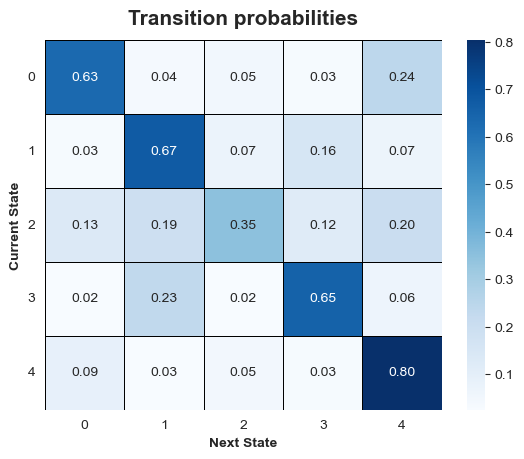

In [80]:
transition_matrix = transition_matrix_prob

#heatmap_figsize=(36,12)
ticks = np.arange(0.5, len(transition_matrix), 1)


communities_name = range(len(transition_matrix))

# Heatmap of the ratio of votes across communities
#plt.figure(figsize=heatmap_figsize)
sns.heatmap(transition_matrix, cmap="Blues", annot=True, fmt=".2f", linewidths=.5, linecolor="black")
plt.title("Transition probabilities",size=15, fontweight='bold', y=1.02)
plt.xlabel("Next State", size=10, fontweight='bold')
plt.ylabel("Current State", size=10, fontweight='bold')
plt.xticks(ticks=ticks,labels=communities_name)
plt.yticks(ticks=ticks, labels=communities_name, rotation='horizontal')
plt.show()

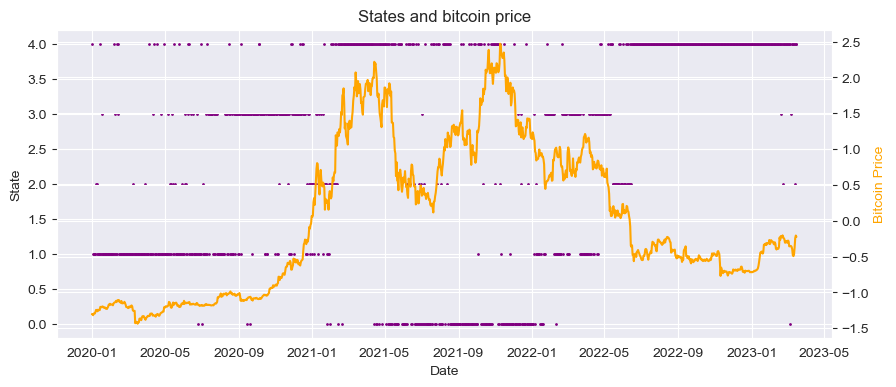

In [81]:
df = pd.DataFrame(list(dict_clusters_time.items()), columns=['Date', 'Value'])
df
df_btc = daily_prices.loc[:, ['Bitcoin']].reset_index()
# Create figure and plot space
fig, ax1 = plt.subplots(figsize=(10, 4))

# Add x-axis and y-axis
ax1.scatter(df['Date'],
           df['Value'],
           color='purple',
           s=1)

# Set title and labels for axes
ax1.set(xlabel="Date",
       ylabel="State",
       title="States and bitcoin price")

ax2 = ax1.twinx()
ax2.plot(df_btc['index'], df_btc['Bitcoin'], color='orange', label='Bitcoin Price')
ax2.set_ylabel("Bitcoin Price", color='orange')

plt.show()